<a href="https://colab.research.google.com/github/sahilpatelskell64/JPMorgan-Chase-Co.-Quantitative-Research-Project/blob/main/JpMorgan_Forage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df_gas = pd.read_csv("/content/Nat_Gas.csv")
df_gas.head()

,Dates,Prices
0,10/31/20,10.1
1,11/30/20,10.3
2,12/31/20,11.0
3,1/31/21,10.9
4,2/28/21,10.9


In [ ]:
# Formatting and cleaning data

# Format Date
df_gas['Dates'] = pd.to_datetime(df_gas['Dates'], dayfirst=False)
df_gas['Dates'] = df_gas['Dates'].dt.strftime('%m-%d-%Y')

# Decided not to format price due to errors in getting summary statistics

df_gas.head()

<ipython-input-80-763906031c3e>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_gas['Dates'] = pd.to_datetime(df_gas['Dates'], dayfirst=False)


,Dates,Prices
0,10-31-2020,10.1
1,11-30-2020,10.3
2,12-31-2020,11.0
3,01-31-2021,10.9
4,02-28-2021,10.9


In [ ]:
import statsmodels as smf
# Exploratory analysis

# Summary statistics
df_gas.describe()

,Prices
count,48.000000
mean,11.207083
std,0.757897
min,9.840000
25%,10.650000
50%,11.300000
75%,11.625000
max,12.800000


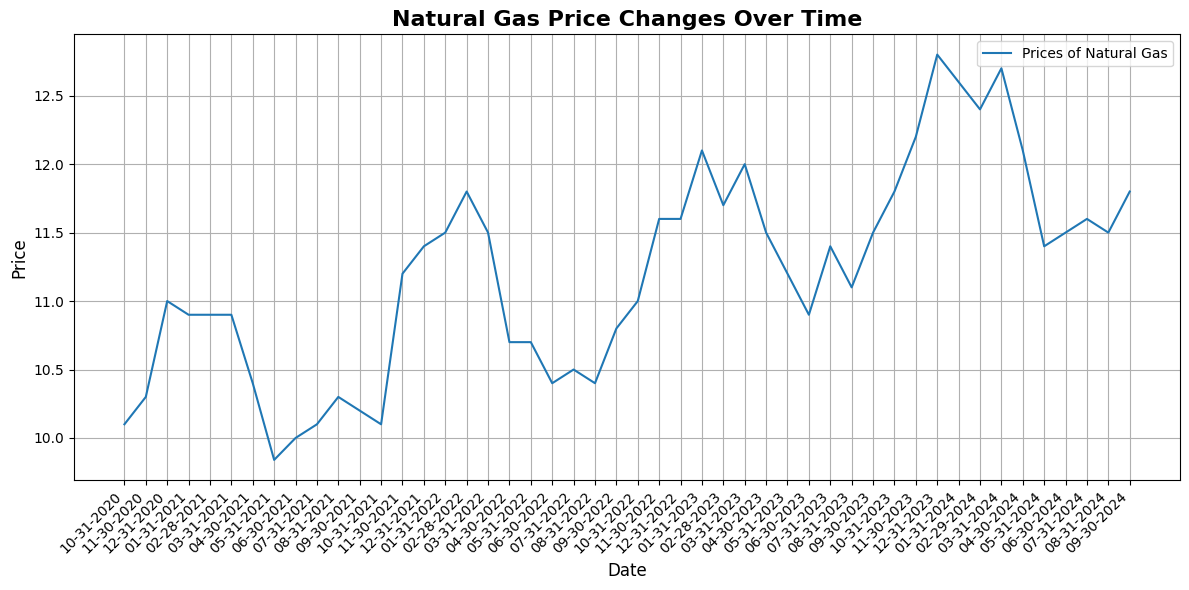

In [ ]:
# Time Series plot
# Plotting price changes over time
import matplotlib.pyplot as plt

x = df_gas['Dates']
y = df_gas['Prices']

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(x,y, label = "Prices of Natural Gas")

ax.set_title('Natural Gas Price Changes Over Time', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price', fontsize=12)

plt.xticks(rotation=45, ha='right')
ax.legend(fontsize=10)
plt.grid()

plt.tight_layout()
plt.show()


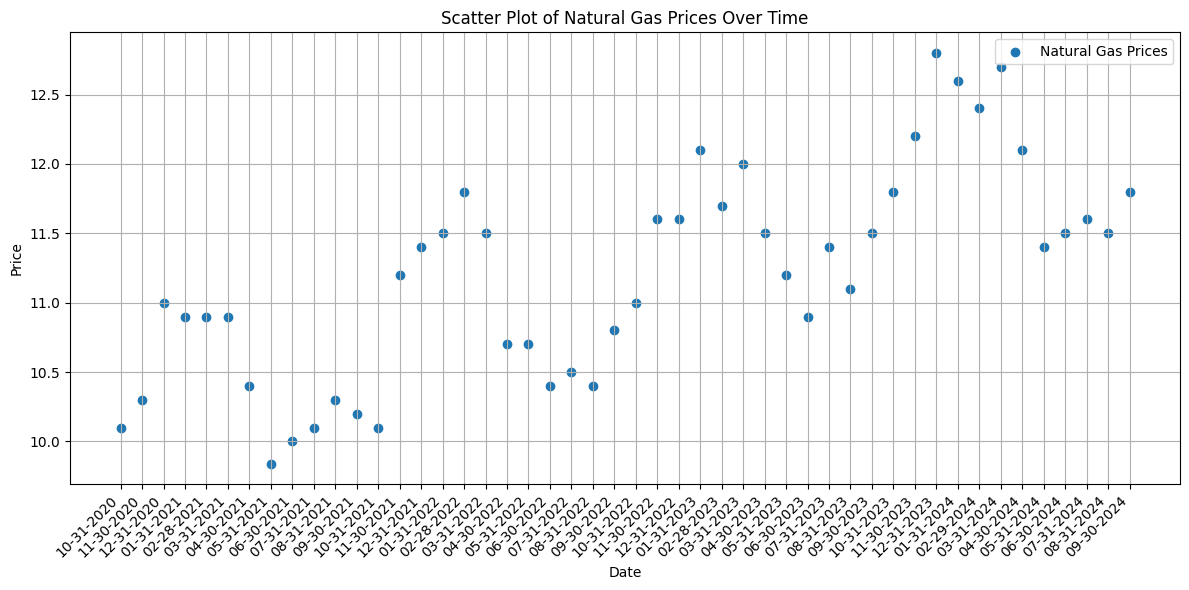

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(df_gas['Dates'], df_gas['Prices'], label='Natural Gas Prices')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Scatter Plot of Natural Gas Prices Over Time')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


From looking at the graph, it appears that there is a seasonality effect. Lets explore that more.

In [ ]:
# Create a new column 'Season' in the DataFrame
df_gas['Month'] = pd.to_datetime(df_gas['Dates']).dt.month

def assign_season(month):
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Autumn'
    else:
        return 'Winter'

df_gas['Season'] = df_gas['Month'].apply(assign_season)

# Now you can filter by season
spring_df = df_gas[df_gas['Season'] == 'Spring']
summer_df = df_gas[df_gas['Season'] == 'Summer']
autumn_df = df_gas[df_gas['Season'] == 'Autumn']
winter_df = df_gas[df_gas['Season'] == 'Winter']

In [ ]:
df_gas.head()

,Dates,Prices,Month,Season
0,10-31-2020,10.1,10,Autumn
1,11-30-2020,10.3,11,Autumn
2,12-31-2020,11.0,12,Winter
3,01-31-2021,10.9,1,Winter
4,02-28-2021,10.9,2,Winter


           Prices  Month
Season                  
Autumn  11.050000   10.0
Spring  11.245000    4.0
Summer  10.808333    7.0
Winter  11.725000    5.0


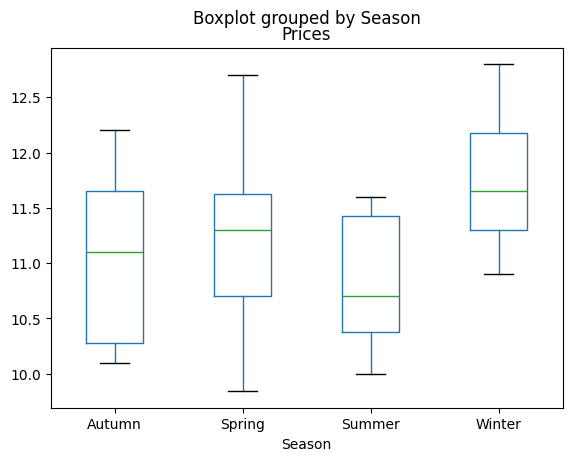

In [ ]:
df_gas.boxplot(column = 'Prices', by = 'Season', grid=False)
print(df_gas.groupby(['Season']).mean(['Prices']))

Looks like the highest prices of natural gas is in Winter, and lowest price is Summer. We can get more granular, but that is not needed right now.

We can conclude that our data is seasonal non-stationarity.

Lets try Holt-Winters' Seasonal Method:

Additive seasonality: xt=Trend+Seasonal+Random

Decomposing the Time Series to look for Levels, Trends, and Seasonality in data

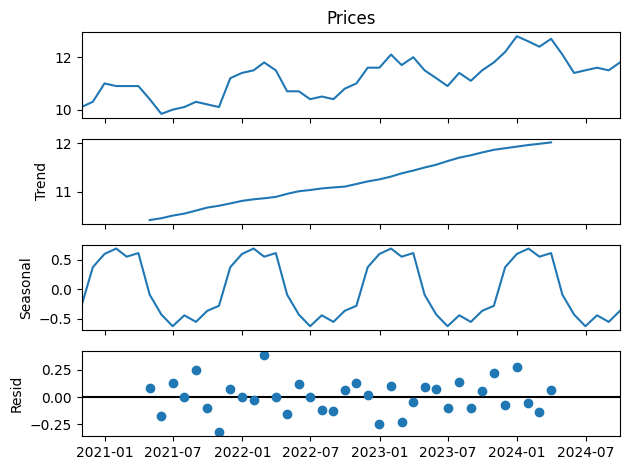

In [ ]:
# time series statsmodels, seasonality decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# holt winters, single exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Set 'Dates' column as the index and convert it to DatetimeIndex
df_gas['Dates'] = pd.to_datetime(df_gas['Dates'])
df_gas = df_gas.set_index('Dates')

# Set the frequency of the DatetimeIndex to month end
df_gas.index.freq = 'ME'

# Now you can perform seasonal decomposition
decompose_result = seasonal_decompose(df_gas['Prices'], model="additive")
decompose_result.plot();

We can clearly see that the data has all 3, Levels, Trends, and Seasonality. Lets fit the data on Single, Double, and Triple Exponential Smoothing to see how it performs

In [ ]:
# Set value of Alpha and define m (time period)
m=4 # due to 4 seasons
alpha = 1/(2*m)

RMSE Value: 0.6029058296138755
MAE Value: 0.48769419762807065


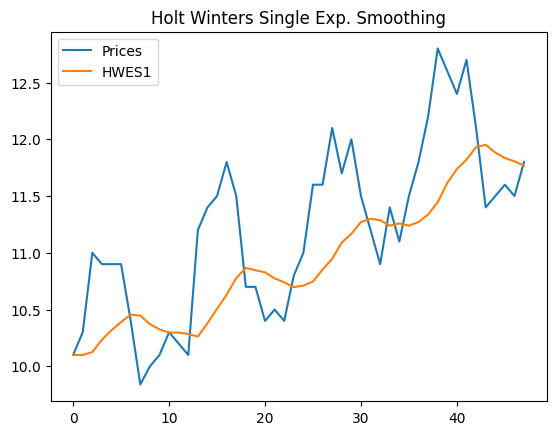

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Fit data on Single Exponential Smoothing
df_gas['HWES1'] = SimpleExpSmoothing(df_gas['Prices']).fit(smoothing_level=alpha, optimized=False, use_brute=True).fittedvalues

df_gas[['Prices','HWES1']].plot(title='Holt Winters Single Exp. Smoothing');

rmse1 = np.sqrt(mean_squared_error(df_gas['Prices'], df_gas['HWES1']))
print("RMSE Value:",rmse1)
mae1 = mean_absolute_error(df_gas['Prices'], df_gas['HWES1'])
print("MAE Value:",mae1)

RMSE Value: 0.38372382248525894
MAE Value: 0.30382978842028446


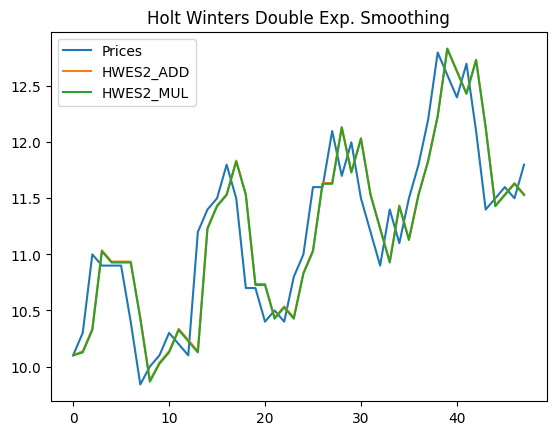

In [ ]:
from sklearn.metrics import mean_squared_error
# Double ES on Additive and Multiplicative Trends
df_gas['HWES2_ADD'] = ExponentialSmoothing(df_gas['Prices'],trend='add').fit().fittedvalues
df_gas['HWES2_MUL'] = ExponentialSmoothing(df_gas['Prices'],trend='mul').fit().fittedvalues

df_gas[['Prices','HWES2_ADD','HWES2_MUL']].plot(title='Holt Winters Double Exp. Smoothing');

rmse2 = np.sqrt(mean_squared_error(df_gas['Prices'], df_gas['HWES2_ADD']))
print("RMSE Value:",rmse2)
mae2 = mean_absolute_error(df_gas['Prices'], df_gas['HWES2_ADD'])
print("MAE Value:",mae2)

RMSE Value: 0.3545830017947591
MAE Value: 0.2800378923465861


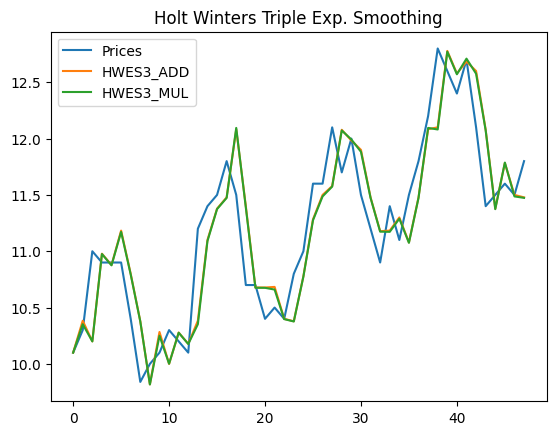

In [ ]:
# Triple HWES
df_gas['HWES3_ADD'] = ExponentialSmoothing(df_gas['Prices'],trend='add', seasonal='add', seasonal_periods=m).fit().fittedvalues
df_gas['HWES3_MUL'] = ExponentialSmoothing(df_gas['Prices'],trend='mul', seasonal='mul', seasonal_periods=m).fit().fittedvalues

df_gas[['Prices','HWES3_ADD','HWES3_MUL']].plot(title='Holt Winters Triple Exp. Smoothing');

rmse3 = np.sqrt(mean_squared_error(df_gas['Prices'], df_gas['HWES3_ADD']))
print("RMSE Value:",rmse3)
mae3 = mean_absolute_error(df_gas['Prices'], df_gas['HWES3_ADD'])
print("MAE Value:",mae3)

Lets Forcast!

In [ ]:
# Creating and fitting the Triple ES Model
forecast_periods = 12
forecast_add_model = ExponentialSmoothing(df_gas['Prices'],trend='add', seasonal='add', seasonal_periods=12).fit()
test_predictions = forecast_add_model.forecast(12)


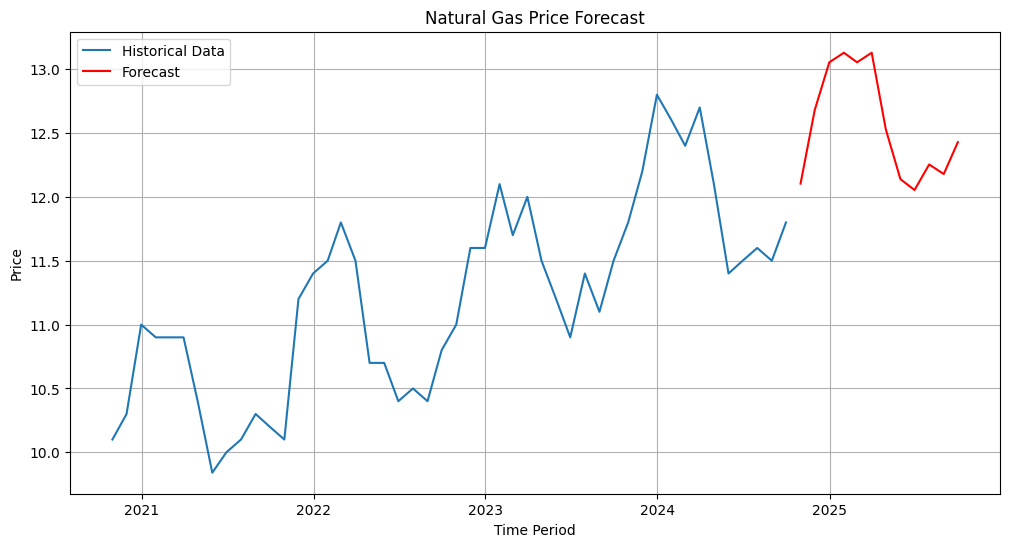

In [ ]:

import matplotlib.pyplot as plt
# Plot historical data and predictions
plt.figure(figsize=(12, 6))
plt.plot(df_gas['Prices'], label='Historical Data')
plt.plot(test_predictions, label='Forecast', color='red')
plt.xlabel('Time Period')
plt.ylabel('Price')
plt.title('Natural Gas Price Forecast')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def get_forecasted_price(date, forecast_series):
    date = pd.to_datetime(date)
    if date in forecast_series.index:
        return round(forecast_series[date], 2)
    else:
        # Interpolate if within reasonable range - this is to be able to enter any date within range, not just end of month dates.
        forecast_series = forecast_series.asfreq('D')  # Convert to daily frequency
        interpolated_series = forecast_series.interpolate(method='quadratic')
        if date in interpolated_series.index:
            return round(interpolated_series[date], 2)

    return "Date is too far out of forecast range."


date_input = "03-11-2025"  # Adjust this based on your forecasted period. NOTE: Max forecast date is 9/30/2025
predicted_price = get_forecasted_price(date_input, test_predictions)
print(f"Forecasted price for {date_input}: {predicted_price}")


Forecasted price for 03-11-2025: 13.1
